In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
raw_data.shape

(20052, 680)

In [4]:
raw_data.head(10)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,The Best Blts,4.375,948.0,19.0,79.0,1042.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Ham and Spring Vegetable Salad with Shallot Vi...,4.375,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Spicy-Sweet Kumquats,3.750,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Korean Marinated Beef,4.375,170.0,7.0,10.0,1272.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Ham Persillade with Mustard Potato Salad and M...,3.750,602.0,23.0,41.0,1696.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [6]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

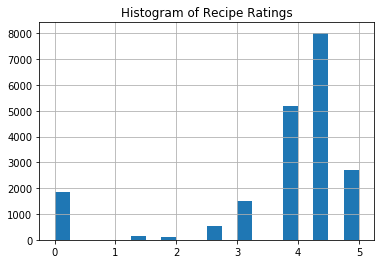

In [7]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [8]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [9]:
# svr = SVR()
# X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
# Y = raw_data.rating
# svr.fit(X,Y)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

In [10]:
# plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [11]:
# svr.score(X, Y)

In [12]:
# cross_val_score(svr, X, Y, cv=5)

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

## First, due to the sparsity of our dataset, in order to find the most important features, let's look at the number of non-zero values per column within our current DataFrame. Further, due to size and complexity, let's change from 20k rows to 5k rows.

In [13]:
raw_data = raw_data.sample(n = 1000)

In [14]:
#Create empty dataframe first
raw_data_non_zero = pd.DataFrame(columns=['Column_Name', 'Count'])

#Go through each column and find the sum of non-zero rows
for col in raw_data:
    non_zero_count = raw_data[col].astype(bool).sum(axis=0)
    raw_data_non_zero = raw_data_non_zero.append({'Column_Name': col, 'Count':non_zero_count}, ignore_index=True)

In [15]:
#Take only our top 30 features and store it in a new variable
New_feature_set = raw_data_non_zero.sort_values('Count', ascending=False).head(30)

In [16]:
#Confirm this worked
New_feature_set['Column_Name']

0                  title
2               calories
5                 sodium
3                protein
4                    fat
1                 rating
63           bon appétit
459          peanut free
580             soy free
642           vegetarian
630        tree nut free
246              gourmet
316               kosher
468          pescatarian
508         quick & easy
38                  bake
660    wheat/gluten-free
603               summer
182              dessert
210                 fall
177           dairy free
667               winter
411       no sugar added
566                 side
312      kidney friendly
185               dinner
428                onion
272              healthy
627               tomato
550                sauté
Name: Column_Name, dtype: object

In [17]:
#Remove title column
New_feature_set = New_feature_set.iloc[1:,]

In [18]:
#Confirm this worked
New_feature_set

,Column_Name,Count
2,calories,999
5,sodium,996
3,protein,968
4,fat,952
1,rating,923
63,bon appétit,483
459,peanut free,391
580,soy free,377
642,vegetarian,339
630,tree nut free,330


In [19]:
#Remove NaN's from existing DataFrame around nutrition
raw_data = raw_data.dropna(subset=['rating', 'title', 'calories', 'protein', 'fat', 'sodium'])

In [20]:
raw_data_revised = raw_data.loc[:,New_feature_set.Column_Name]

In [21]:
raw_data_revised.shape

(811, 29)

## Change our outcome variable to binary

In [22]:
#1 would equal 'Good' rating, 0 would equal 'Bad' rating
raw_data_revised['rating'] = np.where((raw_data['rating'] >= 3), 1, 0)

## Now, determine the baseline accuracy

In [23]:
rating_count = raw_data_revised['rating'].sum()
print('Baseline accuracy for Rating is: ' + str(round((rating_count/raw_data_revised.shape[0])*100, 2)) + '%')

Baseline accuracy for Rating is: 89.77%


## Now run the model with these revised features

In [24]:
#First, instantiate model and fit our data

X = raw_data_revised.drop(columns=['rating'], axis=1)
Y = raw_data_revised.rating

svm = SVC(kernel='linear')
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
svm.score(X,Y)
cross_val_score(svm, X, Y, cv=5)

array([0.89570552, 0.89570552, 0.89570552, 0.90062112, 0.90062112])

## Even after reducing our features, we still see that this model is performing around the baseline. If I were to take this further, I would run an RFE to determine the most important features out of our reduced set, and run the model yet again with fewer features to see if it would have an effect.